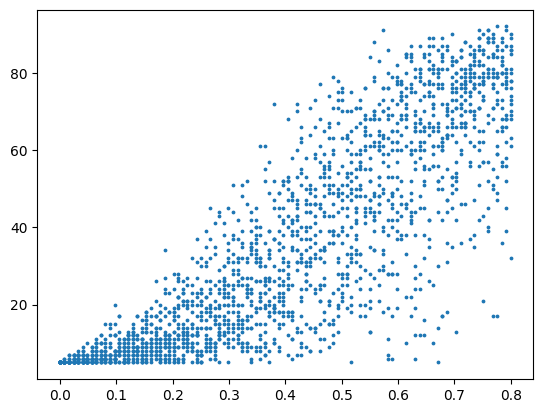

In [30]:
import networkx as nx, numpy as np, random as rd

# Grafo 2d
n_nodes = 10
G = nx.grid_2d_graph(n_nodes,n_nodes,True)
A = nx.adjacency_matrix(G)
adj_mtz = {}
for i in range(n_nodes**2):
    C = list(A.todense()[i])
    ch = {}
    for j in range(len(C)):
        if C[j] == 1:
            ch[j] = {}
    adj_mtz[i] = ch

#list_τ = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
list_τ = np.linspace(0,0.8,100) #np.linspace(0,0.8,200)
r_plot = []
τ_plot = []
repeticoes = 20

for τ in list_τ:
    for i in range(repeticoes):
        
        # Taxa de infecção, recuperação, mobilidade e tempo máximo
        γ = 0.8
        m = 0.9
        tmax = 100

        # Suscetíveis iniciais
        susceptibles_nodes = list(adj_mtz)

        # Infectados iniciais
        n = 0.05*n_nodes*n_nodes
        initial_infections = []
        while len(initial_infections) < n:
            r = rd.choice(list(susceptibles_nodes))
            initial_infections.append(r)
            susceptibles_nodes.pop(susceptibles_nodes.index(r))
        infected_nodes = initial_infections

        # Recuperados iniciais
        n = 0
        recovered_nodes = []
        while len(recovered_nodes) < n:
            r = rd.choice(list(susceptibles_nodes))
            recovered_nodes.append(r)
            susceptibles_nodes.pop(susceptibles_nodes.index(r))

        # Vazios iniciais
        n = 0.05*n_nodes*n_nodes
        empty_nodes = []
        while len(empty_nodes) < n:
            r = rd.choice(list(susceptibles_nodes))
            empty_nodes.append(r)
            susceptibles_nodes.pop(susceptibles_nodes.index(r))

        # Vizinhos vazios
        at_mov_nodes = []
        for n in empty_nodes:
            viz = list(adj_mtz[n])
            for v in viz:
                if v not in empty_nodes:
                    at_mov_nodes.append(v)
        at_mov_nodes = list(set(at_mov_nodes))

        # Taxa de mobilidade
        mobility_rate = np.zeros(len(adj_mtz))
        for n in at_mov_nodes:
            viz = list(adj_mtz[n])
            n_viz = 0
            for vv in viz:
                if vv in empty_nodes:
                    n_viz += 1
            mobility_rate[n] = m*n_viz

        # Vizinhos infectados
        at_risk_nodes = []
        for n in infected_nodes:
            viz = list(adj_mtz[n])
            for v in viz:
                if v in susceptibles_nodes:
                    at_risk_nodes.append(v)
        at_risk_nodes = list(set(at_risk_nodes))

        # Taxa de infecção
        infection_rate = np.zeros(len(adj_mtz))
        for n in at_risk_nodes:
            viz = list(adj_mtz[n])
            n_viz = 0
            for vv in viz:
                if vv in infected_nodes:
                    n_viz += 1
            infection_rate[n] = τ*n_viz

        # Plot
        times = [0]
        S = [len(adj_mtz) - len(initial_infections)]
        I = [len(initial_infections)]
        R = [0]

        # Definindo as taxas de infecção total e recuperação total
        total_infection_rate = np.sum(infection_rate)
        total_recovery_rate = γ*len(infected_nodes)
        total_mobility_rate = np.sum(mobility_rate) # Taxa total de mobilidade
        total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate
        
        stop_rate = total_infection_rate + total_recovery_rate

        # Tempo será selecionado desta forma
        #time = -np.log(rd.random())/total_rate
        time = 0
        
        # Armazenando os nós recuperados e quantos que se moveram para fins de plot.
        moved = [0]
        mob_count = 0

        #print(f'Nós suscetíveis: {susceptibles_nodes}')
        #print(f'Nós infectados: {infected_nodes}')
        #print(f'Nós recuperados: {recovered_nodes}')
        #print(f'Nós vazios: {empty_nodes}')
        #print(at_risk_nodes)
        #print(infection_rate)


        # Início da simulação
        #while time < tmax:
        while stop_rate > 0:

            r = rd.uniform(0,1)
            r_rec = total_recovery_rate/total_rate
            r_inf = total_infection_rate/total_rate
            r_mob = total_mobility_rate/total_rate

            #print('at_risk_nodes', at_risk_nodes)
            #print('infection_rate', infection_rate) 
            
            # Recuperação
            if r < r_rec:

                # Escolho aleatóriamente um infectado
                u = rd.choice(infected_nodes)

                # Atualizo as listas
                infected_nodes.pop(infected_nodes.index(u))
                recovered_nodes.append(u)

                # Atualizo as taxas de infecção
                uviz = list(adj_mtz[u])
                for v in uviz:
                    if v in at_risk_nodes:
                        infection_rate[v] -= τ

                        #print('v: ',v,' infection_rate A : ',infection_rate[v])

                        if infection_rate[v] == 0:
                            at_risk_nodes.pop(at_risk_nodes.index(v))
                
                #print(f'\nRecuperação.')
                #print(f'{u} se recuperou.')
                #print(f'Taxa de infecção:{infection_rate}.')
                #print(f'Nó suscetível: ',susceptibles_nodes)

            # Infecção
            elif r_rec < r <= (r_rec + r_inf):

                #print('I')
                #print('r_inf', r_inf)
                #print('r_rec', r_rec)
                #print('r_mob', r_mob)

                # Seleciono aleatóriamente com peso um nó em risco
                p = infection_rate/total_infection_rate
                p_list_inf = []
                for i in at_risk_nodes:
                    p_list_inf.append(p[i])

                #print('p_list_inf',p_list_inf)
                #print('at_risk_nodes',at_risk_nodes)
                #print('infection_rate', infection_rate)
                #print(len(infected_nodes))

                u = rd.choices(at_risk_nodes, weights=p_list_inf)[0]

                # Atualizo as listas e anulo a taxa de infecção
                susceptibles_nodes.pop(susceptibles_nodes.index(u))
                at_risk_nodes.pop(at_risk_nodes.index(u))
                infection_rate[u] = 0
                
                #print('v: ',u,' infection_rate: ',infection_rate[u])
                
                infected_nodes.append(u)

                uviz = list(adj_mtz[u])
                for v in uviz:
                    if v in susceptibles_nodes:
                        infection_rate[v] += τ

                        #print('v: ',v,' infection_rate B : ',infection_rate[v])

                        if v not in at_risk_nodes:
                            at_risk_nodes.append(v)
            
                #at_risk_nodes = list(set(at_risk_nodes))



                #print('\nInfecção')
                #print(f'{u} se infecta')
                #print(f'Taxa de infecção: {infection_rate}')
                #print(f'Nós infectados: {infected_nodes}')
                #print(f'Nó suscetível: ',susceptibles_nodes)

            # Mobilidade
            elif (r_rec + r_inf) < r <= (r_rec + r_inf + r_mob):

                # Quem vai se mover
                p = mobility_rate/total_mobility_rate
                p_list = []
                for i in at_mov_nodes:
                    p_list.append(p[i])
                u = rd.choices(at_mov_nodes, weights=p_list)[0]

                # Para onde vai se mover
                uviz = list(adj_mtz[u])
                emp_list = []
                for i in uviz:
                    if i in empty_nodes:
                        emp_list.append(i)
                e = rd.choices(emp_list)[0]

                # Atualizo a lista de vazios
                empty_nodes.pop(empty_nodes.index(e))
                empty_nodes.append(u)

                # u

                # Atualizando taxa de mobilidade dos viznhos de u
                u_viz = list(adj_mtz[u])
                for v in u_viz:
                    if v not in empty_nodes:
                        at_mov_nodes.append(v)
                        mobility_rate[v] += m    

                # e

                # Atualizando taxa de mobilidade dos vizinhos de e
                e_viz = list(adj_mtz[e])
                for v in e_viz:
                    if v in at_mov_nodes:
                        at_mov_nodes.pop(at_mov_nodes.index(v))
                        mobility_rate[v] -= m

                # Se u é infectado
                if u in infected_nodes:

                    # Aumentando taxa de infecção após o movimento
                    eviz = list(adj_mtz[e])
                    for v in eviz:
                        if v in susceptibles_nodes:
                            infection_rate[v] += τ

                            #print('v: ',v,' infection_rate C : ',infection_rate[v])

                            if v not in at_risk_nodes:
                                at_risk_nodes.append(v)

                    # Diminuindo a taxa de infecção no novo local vazio
                    uviz = list(adj_mtz[u])
                    for v in uviz:
                        if v in at_risk_nodes:
                            infection_rate[v] -= τ

                            #print('v: ',v,' infection_rate D : ',infection_rate[v])

                            if infection_rate[v] == 0:
                                at_risk_nodes.pop(at_risk_nodes.index(v))
                                
                    infected_nodes.pop(infected_nodes.index(u))
                    infected_nodes.append(e)

                # Se u é suscetível
                elif u in susceptibles_nodes:


                    # Atualizar lista de suscetíveis
                    susceptibles_nodes.pop(susceptibles_nodes.index(u))  
                    susceptibles_nodes.append(e)

                    # at_risk_nodes            
                    if u in at_risk_nodes:
                        at_risk_nodes.pop(at_risk_nodes.index(u))
                        infection_rate[u] = 0

                    # Atualizar taxa de infecção
                    eviz = list(adj_mtz[e])
                    for v in eviz:
                        if v in infected_nodes:
                            infection_rate[e] += τ

                            #print('e: ',e,' infection_rate E : ',infection_rate[e])

                            if e not in at_risk_nodes:
                                at_risk_nodes.append(e)

                # Se u é um recuperado
                elif u in recovered_nodes:

                    # Removo u da lista de recuperados e adiciono 'e' nesta lista
                    recovered_nodes.pop(recovered_nodes.index(u))
                    recovered_nodes.append(e)



            # Armazenando dados para fins de plot
            S.append(len(adj_mtz) - len(infected_nodes) - len(recovered_nodes))

            I.append(len(infected_nodes))

            R.append(len(recovered_nodes))

            times.append(time)

            # Atualizando as taxas e o tempo
            total_recovery_rate = γ*len(infected_nodes)
            total_infection_rate = np.sum(infection_rate)
            total_mobility_rate = m*(len(adj_mtz)) # Taxa total de mobilidade
            total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate
            
            stop_rate = total_infection_rate + total_recovery_rate

            time += 1

        r_plot.append(R[-1])
        τ_plot.append(τ)

plt.scatter(τ_plot,r_plot, s=3)

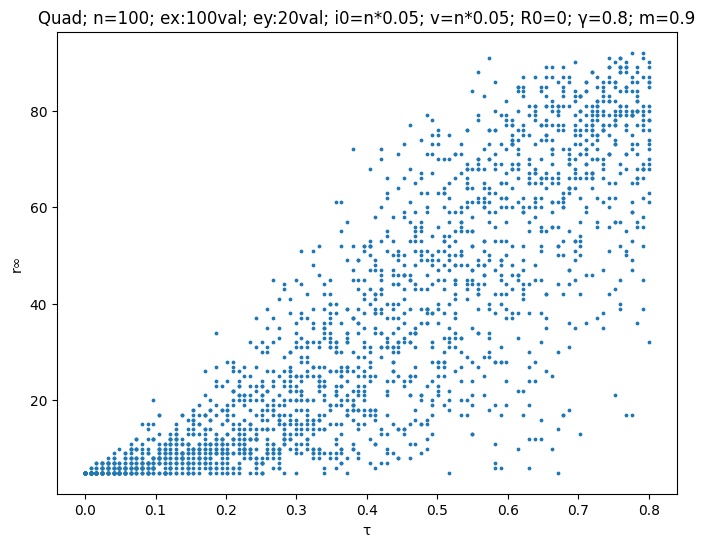

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(τ_plot,r_plot, s=3)
ax.set_xlabel('τ')
ax.set_ylabel('r∞')
ax.set_title(f"Quad; n={n_nodes**2}; ex:100val; ey:20val; i0=n*0.05; v=n*0.05; R0=0; γ={γ}; m={m}")
plt.savefig(f'Quad n={n_nodes**2} m={m} Periodic.pdf')

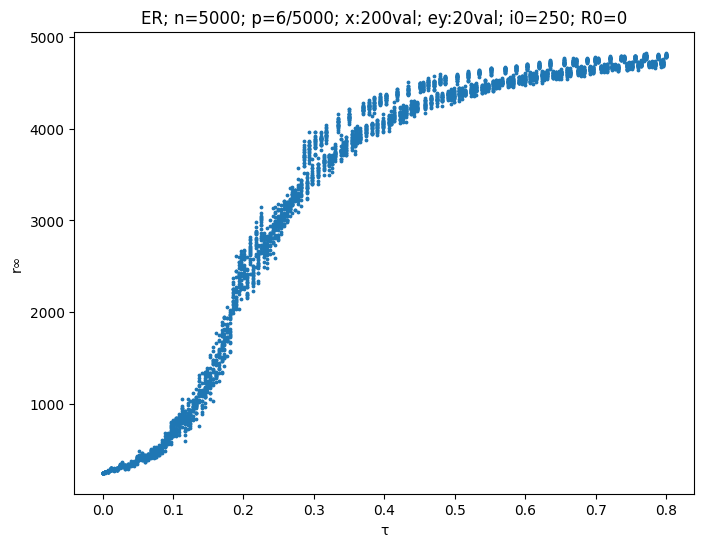

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(τ_plot,r_plot, s=3)
ax.set_xlabel('τ')
ax.set_ylabel('r∞')
ax.set_title("ER; n=5000; p=6/5000; x:200val; ey:20val; i0=250; R0=0")
plt.savefig('figura2.pdf')

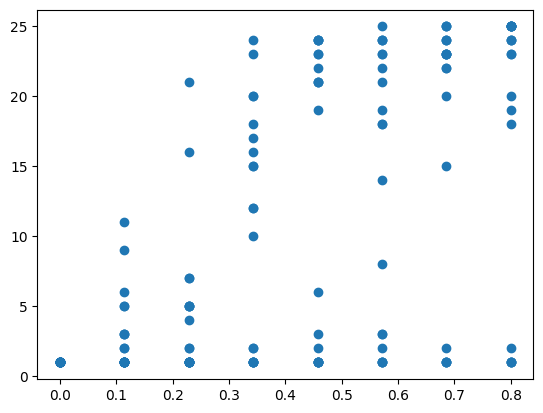

In [45]:
plt.scatter(τ_plot, r_plot)

In [33]:
at_risk_nodes

[]

In [34]:
adj_mtz

{0: {2: {}, 7: {}, 9: {}, 29: {}},
 1: {3: {}, 6: {}, 12: {}, 19: {}, 23: {}, 28: {}},
 2: {0: {}, 5: {}, 8: {}, 13: {}, 16: {}, 19: {}},
 3: {1: {}, 9: {}, 12: {}},
 4: {10: {}, 13: {}, 14: {}, 17: {}, 21: {}, 25: {}},
 5: {2: {}, 12: {}, 24: {}, 26: {}},
 6: {1: {}, 12: {}, 13: {}, 23: {}, 25: {}, 28: {}},
 7: {0: {}, 10: {}, 16: {}, 20: {}, 23: {}},
 8: {2: {}, 12: {}, 16: {}, 24: {}},
 9: {0: {}, 3: {}, 13: {}, 27: {}},
 10: {4: {}, 7: {}, 11: {}, 13: {}, 14: {}, 17: {}, 19: {}, 23: {}, 25: {}},
 11: {10: {}, 12: {}, 19: {}, 21: {}, 22: {}, 29: {}},
 12: {1: {}, 3: {}, 5: {}, 6: {}, 8: {}, 11: {}, 14: {}, 17: {}, 19: {}},
 13: {2: {}, 4: {}, 6: {}, 9: {}, 10: {}, 16: {}, 18: {}, 19: {}, 26: {}},
 14: {4: {}, 10: {}, 12: {}, 16: {}, 19: {}, 21: {}, 23: {}, 24: {}},
 15: {19: {}, 24: {}},
 16: {2: {},
  7: {},
  8: {},
  13: {},
  14: {},
  19: {},
  21: {},
  24: {},
  26: {},
  29: {}},
 17: {4: {}, 10: {}, 12: {}, 21: {}, 29: {}},
 18: {13: {}, 21: {}, 27: {}},
 19: {1: {},
  2: {

In [28]:
n_nodes = 5
G = nx.grid_2d_graph(n_nodes,n_nodes,True)
A = nx.adjacency_matrix(G)
adj_mtz = {}
for i in range(n_nodes**2):
    C = list(A.todense()[i])
    ch = {}
    for j in range(len(C)):
        if C[j] == 1:
            ch[j] = {}
    adj_mtz[i] = ch
adj_mtz

{0: {1: {}, 4: {}, 5: {}, 20: {}},
 1: {0: {}, 2: {}, 6: {}, 21: {}},
 2: {1: {}, 3: {}, 7: {}, 22: {}},
 3: {2: {}, 4: {}, 8: {}, 23: {}},
 4: {0: {}, 3: {}, 9: {}, 24: {}},
 5: {0: {}, 6: {}, 9: {}, 10: {}},
 6: {1: {}, 5: {}, 7: {}, 11: {}},
 7: {2: {}, 6: {}, 8: {}, 12: {}},
 8: {3: {}, 7: {}, 9: {}, 13: {}},
 9: {4: {}, 5: {}, 8: {}, 14: {}},
 10: {5: {}, 11: {}, 14: {}, 15: {}},
 11: {6: {}, 10: {}, 12: {}, 16: {}},
 12: {7: {}, 11: {}, 13: {}, 17: {}},
 13: {8: {}, 12: {}, 14: {}, 18: {}},
 14: {9: {}, 10: {}, 13: {}, 19: {}},
 15: {10: {}, 16: {}, 19: {}, 20: {}},
 16: {11: {}, 15: {}, 17: {}, 21: {}},
 17: {12: {}, 16: {}, 18: {}, 22: {}},
 18: {13: {}, 17: {}, 19: {}, 23: {}},
 19: {14: {}, 15: {}, 18: {}, 24: {}},
 20: {0: {}, 15: {}, 21: {}, 24: {}},
 21: {1: {}, 16: {}, 20: {}, 22: {}},
 22: {2: {}, 17: {}, 21: {}, 23: {}},
 23: {3: {}, 18: {}, 22: {}, 24: {}},
 24: {4: {}, 19: {}, 20: {}, 23: {}}}